In [23]:
import numpy as np
import matplotlib.pyplot as plt
from extra_packages import OutputInterface as oi
from extra_packages import sperhical_expansion as se
import SFALinearPulse as sfa_lin
from matplotlib.colors import LogNorm
from itertools import repeat
import matplotlib as mpl

# Matplotlib asthetics
major = 7.5
minor = 5
width = 1.25
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc("axes", labelsize=16) # 18
plt.rc("xtick", labelsize=14, top=True, direction="in")
plt.rc("ytick", labelsize=14, right=True, direction="in")
plt.rc("axes", titlesize=18)
plt.rc("legend", fontsize=14)
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.linewidth'] = width
plt.rcParams['xtick.minor.width'] = width
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.minor.width'] = width
plt.rcParams['ytick.major.width'] = width
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor

In [24]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [25]:
import multiprocessing

try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default

pool = multiprocessing.Pool(processes=cpus)

In [26]:
output = oi.OutputInterface('output_files/S-fencone_mod2.out')
Ip = abs(output.saved_orbitals[output.HOMO][0])
kappa = np.sqrt(2*Ip)
omega = 0.057     # Frequency of light
Up = 0.22         # Ponderomotive potential
CEP = np.pi/2
N = 2

gto_coeffs = np.array(output.output_GTOs())

In [49]:
plot_list = np.linspace(0.1, 15, 75)
f_lms = se.laplace_several_r(output.eval_orbital_spherical, plot_list, 14, orbital_nr=output.HOMO)

'''r_list = np.linspace(8.5, 10, 50) # 7.0, 7.2 # 7.5 8.0 # 8.0, 9.0 # 9, 10 #
clm_array = se.get_asymp_fit(output.eval_orbital_spherical, r_list, 12, Ip, orbital_nr=output.HOMO, ## 8 ##
                             threshold=1e-3, normalized=False)'''

r_list = np.linspace(8.0, 10.0, 50) # 7.0, 7.2 # 7.5 8.0 # 8.0, 9.0 # 9, 10 #
clm_array = se.get_asymp_fit(output.eval_orbital_spherical, r_list, 14, Ip, orbital_nr=output.HOMO, ## 8 ##
                             threshold=1e-4, normalized=False)


# Get coefficients for other enantiomer via reflection in xy-plane: c_lm -> (-1)^(l+m)c_lm
clm_array2 = np.copy(clm_array)
for l in range(1, len(clm_array[1])):
    clm_array2[0, l, :] = clm_array[1, l, :]
    clm_array2[1, l, :] = clm_array[0, l, :]
#clm_array2[0, :, 1] = clm_array[1, :, 1]

#clm_array /= np.sum(np.abs(clm_array)**2)
#clm_array2 /= np.sum(np.abs(clm_array2)**2)

'''for sgn in range(2):
    for l in range(clm_array.shape[1]):
        for m in range(0, l + 1):
            clm_array2[sgn, l, m] *= (-1)**m'''

for sgn in range(2):
    for l in range(clm_array.shape[1]):
        for m in range(0, l + 1):
            clm_array2[sgn, l, m] *= (-1)**m

#all_coeffs = np.array([np.array(gto_coeffs), np.array(clm_array)], dtype='object')

Evaluating at r=10.0000 	 Nr. 50/50
Now fitting!
Done!


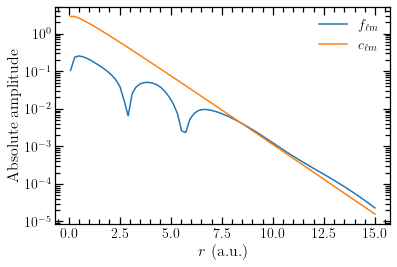

In [50]:
def asymp(r, clm):
    return clm * r**(1/kappa - 1) * np.exp(-kappa*r)

sgn, l, m = 0, 1, 1
plt.figure(facecolor='white')
plt.plot(plot_list, np.abs(f_lms[:, sgn, l, m]), label=r'$f_{\ell m}$')
plt.plot(plot_list, np.abs(asymp(plot_list, clm_array[sgn, l, m])), label=r'$c_{\ell m}$')
plt.xlabel('$r$ (a.u.)')
plt.ylabel('Absolute amplitude')
plt.legend(frameon=False)
plt.yscale('log')
plt.minorticks_on()
plt.show()

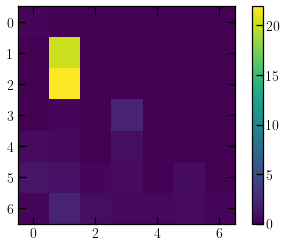

4.680618869170263


In [51]:
plt.imshow(np.abs(clm_array[0])**2, cmap='viridis')
plt.colorbar()
plt.show()
print(np.abs(clm_array[0, 2, 1]))

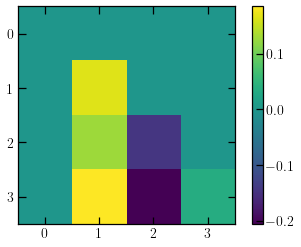

1.4095429309777245


In [67]:
plt.imshow(np.imag(clm_array[0]), cmap='viridis')
plt.colorbar()
plt.show()
print(np.abs(clm_array[0, 2, 1]))

## Save coefficients

In [118]:
# Print out the coefficients
clm_lst = se.convert_clm_array_to_list(clm_array)
print(np.sqrt(len(clm_lst)) - 1)
#np.savetxt('clm_coeffs_re.txt', np.real(clm_lst))
#np.savetxt('clm_coeffs_im.txt', np.imag(clm_lst))
coeffs = []
for re, im in zip(np.real(clm_lst), np.imag(clm_lst)):
    coeffs.append([re, im])
coeffs = np.array(coeffs)
np.savetxt('fenchone_coeffs.txt', coeffs)

5.0


## Plot iso-surfaces

In [30]:
from mayavi import mlab
l = 10
n = 100
iso = 0.01
x, y, z = np.mgrid[-l:l:n*1j, -l:l:n*1j, -l:l:n*1j]
mlab.figure(1, fgcolor=(1, 1, 1), bgcolor=(1, 1, 1))
orbital = output.eval_orbital(x, y, z)

mlab.contour3d(orbital, contours=[iso], transparent=False, color=(1, 0, 0))
mlab.contour3d(orbital, contours=[-iso], transparent=False, color=(0, 0, 1))
mlab.show()

In [52]:
asymp = np.real(se.eval_asymptotic_cart(x, y, z, clm_array, Ip))
iso = 0.01
mlab.figure(1, fgcolor=(1, 1, 1), bgcolor=(1, 1, 1))
mlab.contour3d(asymp, contours=[iso], transparent=False, color=(1, 0, 0))
mlab.contour3d(asymp, contours=[-iso], transparent=False, color=(0, 0, 1))
mlab.show()

## Calculate PMDs

In [53]:
dp = 4. / 200
px_lst = np.arange(-1, 1, dp)
pz_lst = np.arange(-1.5, 1.5, dp)
py = 0.
px_grd, pz_grd = np.meshgrid(px_lst, pz_lst)

sfa = sfa_lin.SFALinearPulse(Ip, Up, omega, 2, np.pi/2, 'asymp_martiny')
M_grd = np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array))))
M_grd2 = np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array2))))
M_sqr = np.abs(np.flip(M_grd, 0))**2
M_sqr2 = np.abs(np.flip(M_grd2, 0))**2
print('Done!')

Done!


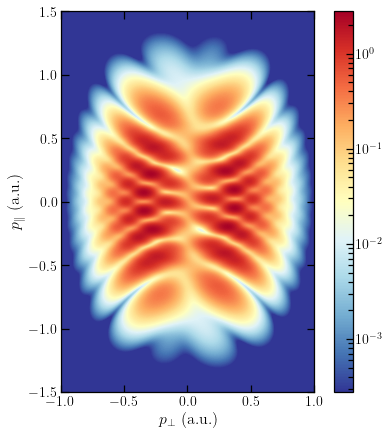

In [58]:
PMD = M_sqr
plt.figure(facecolor='white', figsize=(7, 7))
plt.imshow(PMD, interpolation='bicubic', cmap='RdYlBu_r',
                 norm=LogNorm(vmax=np.max(PMD), vmin=np.max(PMD)*1e-4),
                 extent=(-1, 1, -1.5, 1.5))
plt.xlabel(r'$p_\perp$ (a.u.)')
plt.ylabel(r'$p_\parallel$ (a.u.)')
plt.colorbar()
plt.show()

In [237]:
Ip

0.433

## OAM-resolved PMDs

In [59]:
OAM_grd1 = []
OAM_grd2 = []
OAM_lst = [-3, -2, -1, 1, 2, 3]

dp = 4. / 175#450
px_lst = np.arange(0.01, 1, dp)
pz_lst = np.arange(-1.5, 1.5, dp)
py = 0.
px_grd, pz_grd = np.meshgrid(px_lst, pz_lst)

for OAM in OAM_lst:
    print(f'Doing OAM={OAM}')
    sfa.OAM = OAM
    M_l = np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array))))
    OAM_grd1.append(M_l)
    M_l = np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array2))))
    OAM_grd2.append(M_l)
OAM_grd_tot = [OAM_grd1, OAM_grd2]

Doing OAM=-3
Doing OAM=-2
Doing OAM=-1
Doing OAM=1
Doing OAM=2
Doing OAM=3


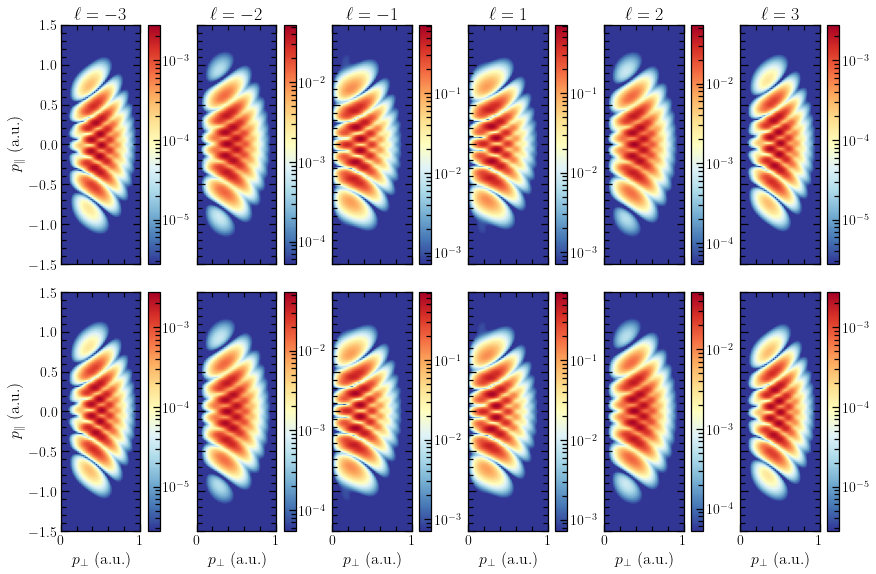

In [60]:
fig, axs = plt.subplots(2, len(OAM_lst), facecolor='white', figsize=(12, 8), constrained_layout=True, sharey='all', sharex='all')
for i in range(2):
    for j in range(len(OAM_lst)):
        im = axs[i, j].imshow(np.abs(OAM_grd_tot[i][j])**2, cmap='RdYlBu_r',
                              norm=LogNorm(vmax=np.max(np.abs(OAM_grd_tot[i][j])**2), vmin=np.max(np.abs(OAM_grd_tot[i][j])**2)*1e-3),
                              extent=(0, 1, -1.5, 1.5))
        plt.colorbar(im, ax=axs[i, j], shrink=1)
        axs[i, j].minorticks_on()
        if i == 0:
            axs[i, j].set_title(f'$\ell={OAM_lst[j]}$')
        if i == 1:
            axs[i, j].set_xlabel(r'$p_\perp$ (a.u.)')
        if j == 0:
            axs[i, j].set_ylabel(r'$p_\parallel$ (a.u.)')
#plt.show()

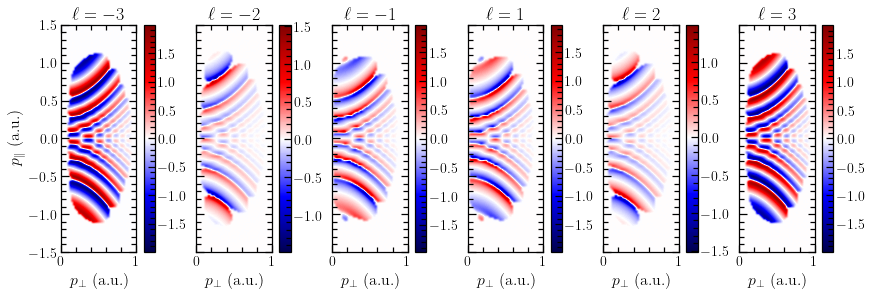

In [61]:
num = len(OAM_lst)
threshold = 0.125e-2
fig, axs = plt.subplots(1, num, facecolor='white', figsize=(12, 15), constrained_layout=True, sharey='all', sharex='all')
count = 0
for ax, Ml1, Ml2, l in zip(axs, OAM_grd_tot[0], OAM_grd_tot[1], OAM_lst):
    Ml1 = np.abs(Ml1)**2
    Ml2 = np.abs(Ml2)**2
    #Ml2 = np.flip(Ml2, 0)
    PEVD = 2*((Ml1 - Ml2)/(Ml1 + Ml2) + 1e-15)
    PEVD = np.nan_to_num(PEVD, nan=0)
    filter_list1 = Ml1 > np.max(Ml1 * threshold)
    filter_list2 = Ml2 > np.max(Ml2 * threshold)
    combined_filter = np.logical_or(filter_list1, filter_list2)
    PEVD[np.logical_not(combined_filter)] = 0
    im = ax.imshow(PEVD, cmap='seismic', norm=MidpointNormalize(np.min(PEVD), np.max(PEVD)), extent=(0, 1, -1.5, 1.5), interpolation='bicubic')
    cbar = plt.colorbar(im, ax=ax)
    cbar.minorticks_on()
    ax.set_xlabel(r'$p_\perp$ (a.u.)')
    ax.minorticks_on()
    if count == 0:
        ax.set_ylabel(r'$p_\parallel$ (a.u.)')
    ax.set_title(f'$\ell={OAM_lst[count]}$')
    count += 1
plt.show()

1.999901975577978
1.4903290854403877
1.9743039802436908


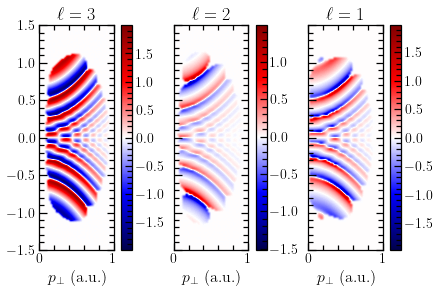

In [62]:
num = len(OAM_lst)
threshold = 0.125e-2
C = 1
fig, axs = plt.subplots(1, 3, facecolor='white', figsize=(6, 10), constrained_layout=True, sharey='all', sharex='all')
for ax, Ml1, Ml2, l in zip(axs,
                           [OAM_grd_tot[C][0], OAM_grd_tot[C][1], OAM_grd_tot[C][2]],
                           [OAM_grd_tot[C][-1], OAM_grd_tot[C][-2], OAM_grd_tot[C][-3]],
                           [3, 2, 1]):
    Ml1 = np.abs(Ml1)**2
    Ml2 = np.abs(Ml2)**2
    #Ml2 = np.flip(Ml2, 0)
    PEVD = 2*((Ml1 - Ml2)/(Ml1 + Ml2))
    PEVD = np.nan_to_num(PEVD, nan=0)
    filter_list1 = Ml1 > np.max(Ml1 * threshold)
    filter_list2 = Ml2 > np.max(Ml2 * threshold)
    combined_filter = np.logical_or(filter_list1, filter_list2)
    PEVD[np.logical_not(combined_filter)] = 0
    print(np.max(PEVD))
    im = ax.imshow(PEVD, cmap='seismic', norm=MidpointNormalize(np.min(PEVD), np.max(PEVD)), extent=(0, 1, -1.5, 1.5), interpolation='bicubic')
    cbar = plt.colorbar(im, ax=ax)
    cbar.minorticks_on()
    ax.set_xlabel(r'$p_\perp$ (a.u.)')
    ax.minorticks_on()
    if count == 0:
        ax.set_ylabel(r'$p_\parallel$ (a.u.)')
    ax.set_title(f'$\ell={l}$')
    count += 1
plt.show()

## ATI spectra

In [56]:
sfa = sfa_lin.SFALinearPulse(Ip, Up, omega, 2, np.pi/2, 'asymp_martiny')
E_lst = np.linspace(0, 0.5, 200)
sfa.OAM = 1
spec1_2 = np.array([sfa.spectra_integrated(E, state_array=clm_array, err=1e-6) for E in E_lst])
sfa.OAM = -1
spec2_2 = np.array([sfa.spectra_integrated(E, state_array=clm_array, err=1e-6) for E in E_lst])

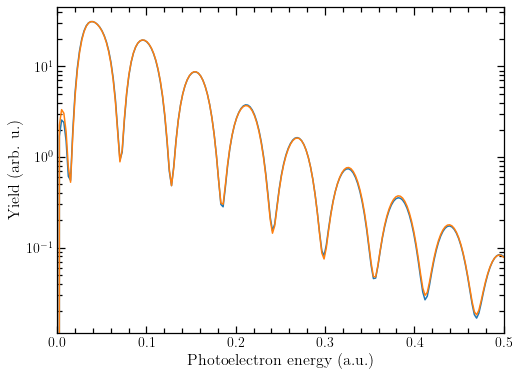

In [59]:
plt.figure(facecolor='white', figsize=(8, 6))
plt.plot(E_lst, spec1_2)
plt.plot(E_lst, spec2_2)
plt.minorticks_on()
plt.xlabel(r'Photoelectron energy (a.u.)')
plt.ylabel(r'Yield (arb. u.)')
plt.xlim(E_lst[0], E_lst[-1])
plt.yscale('log')
plt.show()

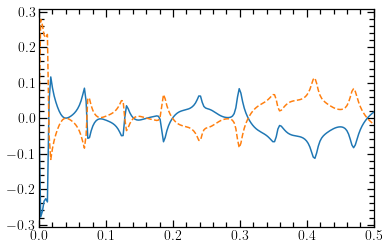

In [58]:
plt.figure(facecolor='white')
res = 2 * (spec1_2 - spec2_2) / (spec1_2 + spec2_2 + 1e-30)
plt.plot(E_lst, res)
plt.plot(E_lst, -res, ls='--')
plt.xlim(E_lst[0], E_lst[-1])
plt.minorticks_on()

## Partially aligned orientation averaging

In [113]:
from sympy.physics.wigner import wigner_3j
def a(l, mu, m1, m2):
    return 2*(-1)**(m2 - m1) * float(wigner_3j(2, l, mu, 0, m2, -m2)) * float(wigner_3j(2, l, mu, 0, m1, -m1)) + (1 if l == mu else 0)/(2*l + 1)

In [114]:
N = 2
dp = 4. / 175#450
px_lst = np.arange(0.01, 1, dp)
pz_lst = np.arange(-1.5, 1.5, dp)
py = 0.
px_grd, pz_grd = np.meshgrid(px_lst, pz_lst)
sfa_lm = sfa_lin.SFALinearPulse(Ip, Up, omega, N, CEP, 'single_clm')
l_max = clm_array.shape[1]

M_avg = np.zeros((px_grd.shape[0], px_grd.shape[1]), dtype='complex')

count = 0
for l in range(l_max):
    for mu in range(l_max):
        for m1 in range(-l, l + 1):
            for m2 in range(-l, l + 1):
                sgn1 = 0 if m1 >= 0 else 1
                lm_lst1 = [l, m2]
                lm_lst2 = [mu, m2]
                clm1 = clm_array[sgn1, l, abs(m1)]
                clm2 = clm_array[sgn1, mu, abs(m1)]
                if np.abs(clm1) == 0 or np.abs(clm2) == 0:
                    continue
                M1 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array(lm_lst1))))
                M2 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array(lm_lst2))))
                M_avg += clm1 * np.conjugate(clm2) * a(l, mu, m1, m2) * np.array(M1) * np.conjugate(np.array(M2))
                print(f'Number {count}')
                count += 1

Number 0
Number 1
Number 2
Number 3
Number 4
Number 5
Number 6
Number 7
Number 8
Number 9
Number 10
Number 11
Number 12
Number 13
Number 14
Number 15
Number 16
Number 17
Number 18
Number 19
Number 20
Number 21
Number 22
Number 23
Number 24
Number 25
Number 26
Number 27
Number 28
Number 29
Number 30
Number 31
Number 32
Number 33
Number 34
Number 35
Number 36
Number 37
Number 38
Number 39
Number 40
Number 41
Number 42
Number 43
Number 44
Number 45
Number 46
Number 47
Number 48
Number 49
Number 50
Number 51
Number 52
Number 53
Number 54
Number 55
Number 56
Number 57
Number 58
Number 59
Number 60
Number 61
Number 62
Number 63
Number 64
Number 65
Number 66
Number 67
Number 68
Number 69
Number 70
Number 71
Number 72
Number 73
Number 74
Number 75
Number 76
Number 77
Number 78
Number 79
Number 80
Number 81
Number 82
Number 83
Number 84
Number 85
Number 86
Number 87
Number 88
Number 89
Number 90
Number 91
Number 92
Number 93
Number 94
Number 95
Number 96
Number 97
Number 98
Number 99
Number 100

In [115]:
OAM_lst = [1, 2]
threshold = 0.125e-2
M_p_avg = np.zeros((len(OAM_lst), px_grd.shape[0], px_grd.shape[1]), dtype='complex')
M_m_avg = np.zeros((len(OAM_lst), px_grd.shape[0], px_grd.shape[1]), dtype='complex')
PEVD_lst = []
count = 0

for i, OAM in enumerate(OAM_lst):
    for l in range(l_max):
        for mu in range(l_max):
            for m in range(-l, l + 1):
                sgn = 0 if m >= 0 else 1
                clm1 = clm_array[sgn, l, abs(m)]
                clm2 = clm_array[sgn, mu, abs(m)]
                if np.abs(clm1) == 0 or np.abs(clm2) == 0:
                    continue
                Mp1 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array([l, OAM]))))
                Mp2 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array([mu, OAM]))))
                M_p_avg[i] += clm1 * np.conjugate(clm2) * a(l, mu, OAM, m) * np.array(Mp1) * np.conjugate(np.array(Mp2))

                Mm1 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array([l, -OAM]))))
                Mm2 = pool.starmap(sfa_lm.Mxz_List, zip(px_grd, repeat(0.0), pz_grd, repeat(np.array([mu, -OAM]))))
                M_m_avg[i] += clm1 * np.conjugate(clm2) * a(l, mu, -OAM, m) * np.array(Mm1) * np.conjugate(np.array(Mm2))
                print(f'Number {count} w/ OAM ±{OAM}', end='\r')
                count += 1

for Mp, Mm in zip(M_p_avg, M_m_avg):
    PEVD = 2*((Mp - Mm)/(Mp + Mm + 1e-30))
    PEVD = np.nan_to_num(PEVD, nan=0)
    filter_list1 = Mp > np.max(Mp * threshold)
    filter_list2 = Mm > np.max(Mm * threshold)
    combined_filter = np.logical_or(filter_list1, filter_list2)
    PEVD[np.logical_not(combined_filter)] = 0
    PEVD_lst.append(PEVD)


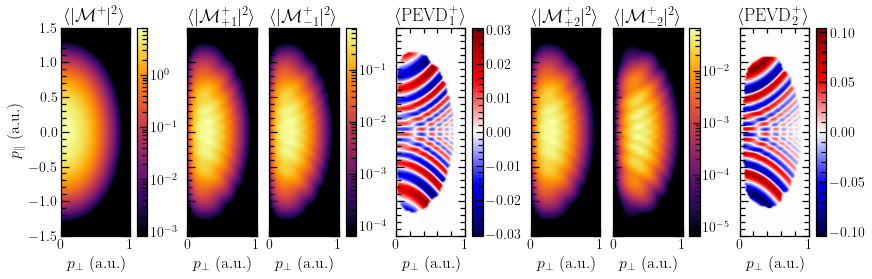

In [116]:
M_avg = np.real(M_avg)
M_p_avg = np.real(M_p_avg)
M_m_avg = np.real(M_m_avg)
#PEVD_lst = np.real(PEVD_lst)
M_max = np.max(np.real(M_avg))


fig, ax = plt.subplots(1, 7, figsize=(12, 6), facecolor='white', sharey='all', constrained_layout=True)
im1 = ax[0].imshow(M_avg, cmap='inferno', norm=LogNorm(vmax=M_max, vmin=M_max*1e-4), interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[0].set_ylabel(r'$p_\parallel$ (a.u.)')
ax[0].set_title(r'$\langle|\mathcal{M}^+|^2\rangle$')

im2 = ax[1].imshow(M_p_avg[0], cmap='inferno', norm=LogNorm(vmax=np.max(M_p_avg[0]), vmin=np.max(M_p_avg[0])*1e-4), interpolation='bicubic',
                   extent=(0, 1, -1.5, 1.5))
ax[1].set_title(r'$\langle|\mathcal{M}^+_{+1}|^2\rangle$')

im3 = ax[2].imshow(M_m_avg[0], cmap='inferno', norm=LogNorm(vmax=np.max(M_m_avg[0]), vmin=np.max(M_m_avg[0])*1e-4), interpolation='bicubic',
                   extent=(0, 1, -1.5, 1.5))
ax[2].set_title(r'$\langle|\mathcal{M}^+_{-1}|^2\rangle$')

im4 = ax[3].imshow(np.real(PEVD_lst[0]), cmap='seismic', interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[3].set_title(r'$\langle\text{PEVD}^+_1\rangle$')

im5 = ax[4].imshow(M_p_avg[0], cmap='inferno', norm=LogNorm(vmax=np.max(M_p_avg[0]), vmin=np.max(M_p_avg[0])*1e-4), interpolation='bicubic',
                   extent=(0, 1, -1.5, 1.5))
ax[4].set_title(r'$\langle|\mathcal{M}^+_{+2}|^2\rangle$')

im6 = ax[5].imshow(M_m_avg[1], cmap='inferno', norm=LogNorm(vmax=np.max(M_m_avg[1]), vmin=np.max(M_m_avg[1])*1e-4), interpolation='bicubic',
                   extent=(0, 1, -1.5, 1.5))
ax[5].set_title(r'$\langle|\mathcal{M}^+_{-2}|^2\rangle$')

im7 = ax[6].imshow(np.real(PEVD_lst[1]), cmap='seismic', interpolation='bicubic', extent=(0, 1, -1.5, 1.5))
ax[6].set_title(r'$\langle\text{PEVD}^+_2\rangle$')

fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[2])
cbar = fig.colorbar(im4, ax=ax[3])
cbar.minorticks_on()
fig.colorbar(im6, ax=ax[5])
cbar2 = fig.colorbar(im7, ax=ax[6])
cbar2.minorticks_on()

for axi in ax:
    axi.set_xlabel(r'$p_\perp$ (a.u.)')
    axi.minorticks_on()